In [1]:
#Libraries
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Daily

In [2]:
#Functions for XGRegressor
def HyperParameterTuning(X_train,y_train,param_grid):
    regressor=XGBRegressor(eval_metric='rmsle')
    search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train) #This function looks for the best parameters for the model.It is essential to have it as we are applying the ML on different datasets
    print("The best hyperparameters are ",search.best_params_)
    return search

def trainModel(search,X_train,y_train):
    regressor=XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

    regressor.fit(X_train, y_train)
    return regressor

def EvaluateModel(X_test,Actual_Values,regressor):
    Predicted_Values = regressor.predict(X_test)

    # Actual VS predicted results 
    results_df = pd.DataFrame({'Actual': Actual_Values, 'Predicted': Predicted_Values})
    print("Actual vs. Predicted Values:")
    print(results_df)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(Actual_Values, Predicted_Values, color='red')
    plt.plot([Actual_Values.min(), Actual_Values.max()], [Actual_Values.min(), Actual_Values.max()])
    plt.xlabel('Actual Target')
    plt.ylabel('Predicted Target')
    plt.title('Actual vs. Predicted Target')
    plt.show()

    # Metrics Evaluation
    mae = mean_absolute_error(Actual_Values, Predicted_Values)
    mape = mean_absolute_percentage_error(Actual_Values,Predicted_Values)
    r2_Score = r2_score(Actual_Values, Predicted_Values)
    rmse =np.sqrt(mean_squared_error(Actual_Values,Predicted_Values))

    metrics = {
        'Metric': ['Mean Absolute Error', 'Root Mean Squared Error', 'Mean Absolute Percentage Error', 'R2 Score'],
        'Value': [f'{mae:.2f}', f'{rmse:.2f}', f'{(mape*100):.2f}%', f'{r2_Score:.2f}']
    }
    metrics_Table = pd.DataFrame(metrics)
    print(metrics_Table)

    # Additional metrics to tackle the extremly high MAPE.a capped mape help gives a better understanding when the model is way off the predictions
    percentage_errors = np.abs((Actual_Values - Predicted_Values) / np.maximum(np.abs(Actual_Values), 1e-10)) * 100
    capped_errors = np.minimum(percentage_errors, 100)
    
    capped_mape = np.mean(capped_errors)
    print("Capped Mape: ",capped_mape )


def splittingData(data,y_column):
    X_columns = ['Open', 'High', 'Low']  # Features
    X = data[X_columns]  
    y = data[y_column]  # Target
    
    # Splitting into training and testing 
    X_train, X_test, y_train, Actual_Values = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, Actual_Values

In [3]:
# Load your dataset and convert the date column to datetime type
data = pd.read_csv('/Users/aliabouyahia/Downloads/Data/JPM-Daily.csv')
data['Date'] = pd.to_datetime(data['Date'])
data['Open'] = data['Open'].shift(1)
data['High'] = data['High'].shift(1)
data['Low'] = data['Low'].shift(1)
data = data.iloc[1:]

The best hyperparameters are  {'learning_rate': 0.001, 'max_depth': 8, 'n_estimators': 1000}
Actual vs. Predicted Values:
          Actual   Predicted
4939  107.610001   92.854233
5821  138.559998  113.273041
4260   84.070000   79.003906
1667   45.459999   53.450966
2802   45.959999   53.973602
...          ...         ...
3932   65.940002   67.688370
1095   35.750000   47.065266
1122   37.619999   47.999092
1761   47.790001   55.288101
4146   57.610001   62.851818

[1208 rows x 2 columns]
                           Metric   Value
0             Mean Absolute Error   11.69
1         Root Mean Squared Error   14.00
2  Mean Absolute Percentage Error  21.18%
3                        R2 Score    0.86


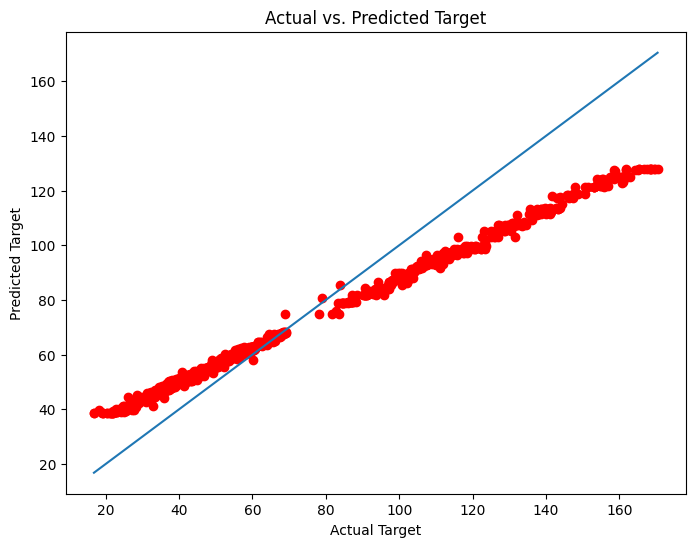

Capped Mape:  21.108301545245666


In [5]:
X_train, X_test, y_train, Actual_Values=splittingData(data,"Close")
param_grid =        {"max_depth":    [2,3,4, 5, 6,7,8],
                    "n_estimators": [1000],
                    "learning_rate": [0.001, 0.0003]}
search = HyperParameterTuning(X_train,y_train,param_grid)
regressor = trainModel(search,X_train,y_train)
EvaluateModel(X_test,Actual_Values,regressor)

# Weekly

In [6]:
data = pd.read_csv('/Users/aliabouyahia/Downloads/Data/JPM-Weekly.csv')
data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y") #The weekly data set format was returning a format error , this is to ensure readability from the CSV.
data['Open'] = data['Open'].shift(1)
data['High'] = data['High'].shift(1)
data['Low'] = data['Low'].shift(1)
data = data.iloc[1:]

The best hyperparameters are  {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 1000}
Actual vs. Predicted Values:
          Actual   Predicted
722    53.959999   57.351082
1244  146.429993  110.778999
1068   92.589996   89.445793
902    84.519997   79.858879
1108  153.710007  123.074158
...          ...         ...
629    37.209999   47.245770
744    55.299999   63.572567
244    39.799999   49.559727
673    41.080002   50.333149
891    87.180000   79.858879

[251 rows x 2 columns]
                           Metric   Value
0             Mean Absolute Error   12.31
1         Root Mean Squared Error   14.73
2  Mean Absolute Percentage Error  21.72%
3                        R2 Score    0.86


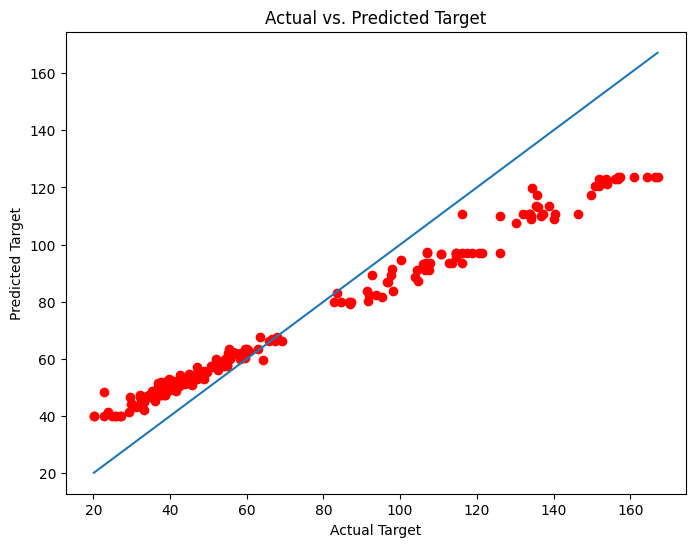

Capped Mape:  21.663587481191236


In [7]:
X_train, X_test, y_train, Actual_Values=splittingData(data,"Close") #Predicting only the close price
param_grid =        {"max_depth":    [2,3,4, 5, 6,7,8],
                    "n_estimators": [1000],
                    "learning_rate": [0.001, 0.0003]}
search = HyperParameterTuning(X_train,y_train,param_grid)
regressor = trainModel(search,X_train,y_train)
EvaluateModel(X_test,Actual_Values,regressor)

Saving the file in HTML is way to not have to re run the code and see several outputs.This is to facilitate the code consultation while marking
The code below has been extracted online and is only use for file conversion as saving as HTML built in function was causing trouble.

In [1]:
import nbformat
from nbconvert import HTMLExporter

# Load the notebook
with open('/Users/aliabouyahia/Desktop/Code_Final_Project_1737703/Machine Learning Algorithms/XGBoost1.ipynb','r') as f:
    notebook = nbformat.read(f, as_version=4)

# Convert to HTML
Export_To_HTML = HTMLExporter()
content, resources = Export_To_HTML.from_notebook_node(notebook)

# Write to an HTML file
with open('XGBoost1.html', 'w') as f:
    f.write(content)
